# Movies genre classifier 

Aim is to build a machine learning model to predict the genre of a movie based on its plot summary or textual information. To achieve this, we will leverage natural language processing (NLP) techniques, specifically TF-IDF (Term Frequency-Inverse Document Frequency), in conjunction with the Naive Bayes classification algorithm.

The primary goal is to create a model that can automatically assign one or more genres to a movie based on the textual description provided. This can be valuable for categorizing and organizing movies in databases, recommendation systems, and content filtering.

## importing liraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

## Loading Dataset

In [2]:
# Load the training data
train_path = "Genre Classification Dataset/train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

# Load the test data
test_path = "Genre Classification Dataset/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')


In [3]:
train_data

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [4]:
test_data

,Title,Genre,Description
1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),drama,Before he was known internationally as a mart...
...,...,...,...
54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Da..."
54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their...
54198,Oliver Twink (2007),adult,A movie 169 years in the making. Oliver Twist...
54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard..."


## EDA & Visualization

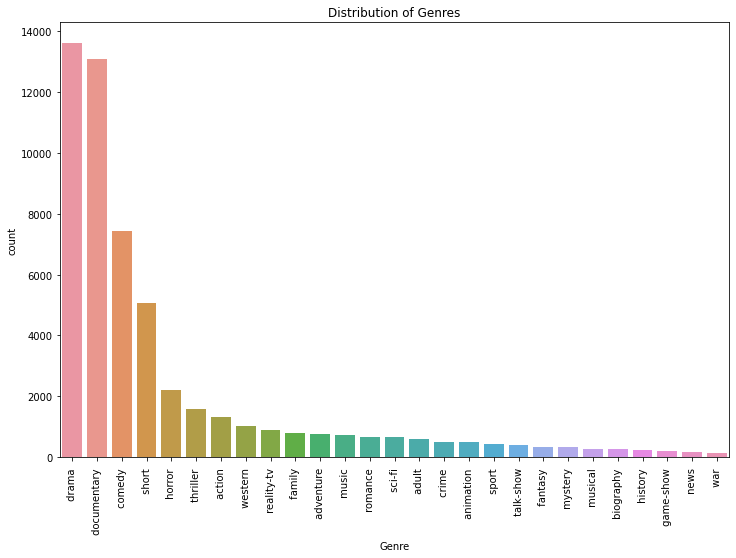

In [5]:
# Plot the distribution of genres using a bar plot sortin  by their count

plt.figure(figsize=(12, 8))
sns.countplot(x='Genre', data=train_data, order=train_data['Genre'].value_counts().index)
plt.title('Distribution of Genres')

# make the names of the genres vertical
plt.xticks(rotation=90)

plt.show()

## Data Preprocessing and Text Cleaning


In [6]:
# Initialize the stemmer and stop words

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# define a function to clean the text

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    # Remove URLs and images
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'https\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'pic\S+', '', text)
    text = re.sub(r'img\S+', '', text)
    text = re.sub(r'image\S+', '', text)
    text = re.sub(r'jpg\S+', '', text)
    # Keep only characters
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.strip()
    text = text.split()

    text = [stemmer.stem(word) for word in text if word not in stop_words]
    text = ' '.join(text)
    return text


In [7]:
# Clean the text in the training data
train_data['Description'] = train_data['Description'].apply(clean_text)


In [8]:
train_data['Description']

1        listen convers doctor parent yearold oscar lea...
2        brother sister past incestu relationship curre...
3        bu empti student field trip museum natur histo...
4        help unemploy father make end meet edith twin ...
5        film titl refer unrecov bodi ground zero also ...
                               ...                        
54210    shortliv nbc live sitcom center bonino worldfa...
54211    next gener exploit sister kapa bay soror hous ...
54212    ze bestaan echt standup comedi grow face fear ...
54213    walter vivian live countri difficult time keep...
54214    labor day weekend intens hurrican ever make la...
Name: Description, Length: 54214, dtype: object

In [9]:

# Clean the text in the test data
test_data['Description'] = test_data['Description'].apply(clean_text)

C:\Users\moham\AppData\Local\Temp\ipykernel_12436\3018855667.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['length_Text_cleaning'], bins=100, kde=False)


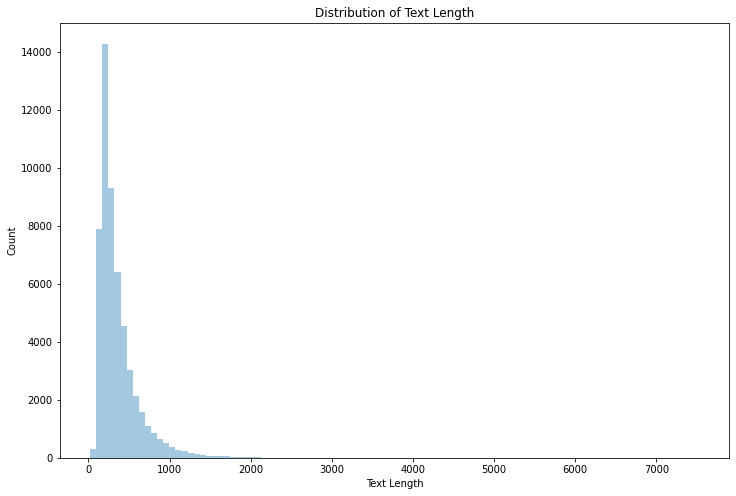

In [10]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Description'].apply(len)

# Visualize the distribution of text lengths
plt.figure(figsize=(12, 8))
sns.distplot(train_data['length_Text_cleaning'], bins=100, kde=False)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()


## split data


In [44]:
# Split the data into training and validation sets
X_train = train_data['Description']
y_train = train_data['Genre']
X_test = test_data['Description']
y_test = test_data['Genre']

In [45]:
X_train

1        listen convers doctor parent yearold oscar lea...
2        brother sister past incestu relationship curre...
3        bu empti student field trip museum natur histo...
4        help unemploy father make end meet edith twin ...
5        film titl refer unrecov bodi ground zero also ...
                               ...                        
54210    shortliv nbc live sitcom center bonino worldfa...
54211    next gener exploit sister kapa bay soror hous ...
54212    ze bestaan echt standup comedi grow face fear ...
54213    walter vivian live countri difficult time keep...
54214    labor day weekend intens hurrican ever make la...
Name: Description, Length: 54214, dtype: object

## Text Vectorization Using TF-IDF

In [46]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


## Building the model

In [28]:
# Train the model using Multinomial Naive Bayes
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print a classification report for more detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.5190590405904059


c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.56      0.10      0.17      1314
       adult        0.53      0.08      0.14       590
   adventure        0.79      0.09      0.15       775
   animation        0.00      0.00      0.00       498
   biography        0.00      0.00      0.00       264
      comedy        0.53      0.43      0.48      7446
       crime        0.00      0.00      0.00       505
 documentary        0.56      0.86      0.68     13096
       drama        0.46      0.82      0.59     13612
      family        0.00      0.00      0.00       783
     fantasy        0.00      0.00      0.00       322
   game-show        0.97      0.16      0.27       193
     history        0.00      0.00      0.00       243
      horror        0.71      0.35      0.47      2204
       music        0.72      0.11      0.19       731
     musical        0.00      0.00      0.00       276
     mystery        0.00      0.00      0.00       318
        n

c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## balancing the data to gain in accuracy



In [37]:
# balance data

ros = RandomOverSampler(random_state=0)
X_train_tfidf_ros, y_train_ros = ros.fit_resample(X_train_tfidf, y_train)

print(X_train_tfidf.shape[0], 'train samples')



367551 train samples


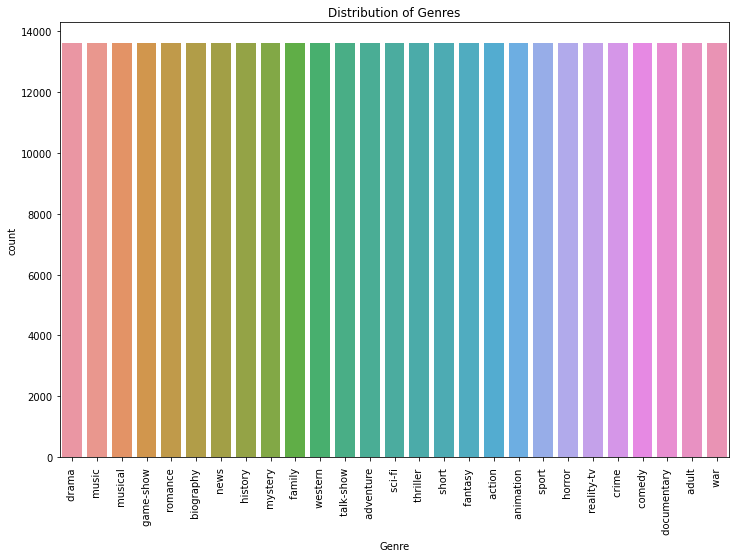

In [38]:

# see the distribution of y_train after balancing the data

plt.figure(figsize=(12, 8))
sns.countplot(x=y_train_ros, order=y_train_ros.value_counts().index)
plt.title('Distribution of Genres')
plt.xticks(rotation=90)
plt.show()



In [39]:
# Train the model using Multinomial Naive Bayes with class weights
classifier = MultinomialNB()


In [40]:

classifier.fit(X_train_tfidf_ros, y_train_ros)

MultinomialNB()

In [41]:
# Make predictions on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print a classification report for more detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.4598708487084871
               precision    recall  f1-score   support

      action        0.33      0.46      0.38      1314
       adult        0.36      0.58      0.45       590
   adventure        0.20      0.24      0.22       775
   animation        0.18      0.25      0.21       498
   biography        0.04      0.12      0.06       264
      comedy        0.58      0.44      0.50      7446
       crime        0.12      0.31      0.18       505
 documentary        0.75      0.55      0.63     13096
       drama        0.68      0.43      0.52     13612
      family        0.18      0.25      0.21       783
     fantasy        0.12      0.26      0.16       322
   game-show        0.66      0.67      0.67       193
     history        0.06      0.20      0.09       243
      horror        0.53      0.64      0.58      2204
       music        0.31      0.75      0.44       731
     musical        0.10      0.17      0.13       276
     mystery        0.08      0.14 

In [49]:
# smote

smote = SMOTE(random_state=0)
X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print(X_train_tfidf.shape[0], 'train samples')

54214 train samples


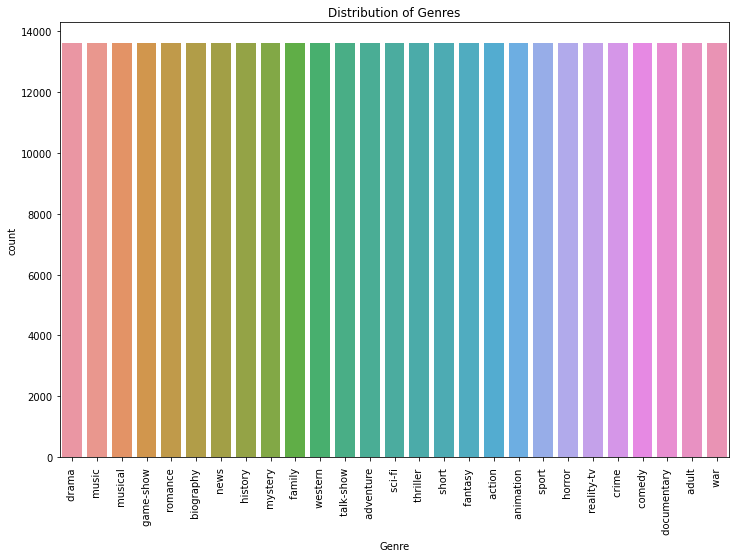

In [50]:

# see the distribution of y_train after balancing the data

plt.figure(figsize=(12, 8))
sns.countplot(x=y_train_smote, order=y_train_smote.value_counts().index)
plt.title('Distribution of Genres')
plt.xticks(rotation=90)
plt.show()



In [51]:
# train

classifier = MultinomialNB()
classifier.fit(X_train_tfidf_smote, y_train_smote)



MultinomialNB()

In [52]:
# Make predictions on the test set

y_pred = classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print a classification report for more detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.4683763837638376
               precision    recall  f1-score   support

      action        0.33      0.45      0.38      1314
       adult        0.39      0.55      0.45       590
   adventure        0.22      0.25      0.23       775
   animation        0.19      0.25      0.22       498
   biography        0.05      0.15      0.07       264
      comedy        0.57      0.46      0.51      7446
       crime        0.13      0.30      0.18       505
 documentary        0.74      0.56      0.64     13096
       drama        0.67      0.43      0.53     13612
      family        0.19      0.26      0.22       783
     fantasy        0.13      0.27      0.17       322
   game-show        0.73      0.65      0.68       193
     history        0.07      0.22      0.10       243
      horror        0.55      0.63      0.58      2204
       music        0.32      0.73      0.45       731
     musical        0.10      0.16      0.13       276
     mystery        0.09      0.15 